<a href="https://colab.research.google.com/github/TamTran72111/learn-ml-dl/blob/master/Augelien_Geron_book/17_Representation_Learning_and_Generative_Learning_using_Autoencoders_and_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performing PCA with an Undercomplete Linear Autoencoder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
  angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
  data = np.empty((m, 3))
  data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
  data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
  data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
  return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-5))

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2704
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 11/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2704
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2704
Epoch 13/20
2/2 [==============================] - 0s 3ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

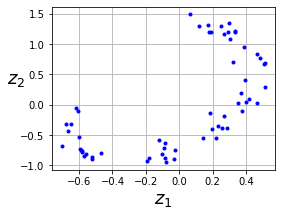

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# Stacked Autoencoders

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.SGD(lr=1.5),
                   metrics=[rounded_accuracy])

history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3374 - rounded_accuracy: 0.8879 - val_loss: 0.3143 - val_rounded_accuracy: 0.9113
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3072 - rounded_accuracy: 0.9135 - val_loss: 0.3044 - val_rounded_accuracy: 0.9182
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3006 - rounded_accuracy: 0.9192 - val_loss: 0.3025 - val_rounded_accuracy: 0.9141
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2970 - rounded_accuracy: 0.9227 - val_loss: 0.2970 - val_rounded_accuracy: 0.9244
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2943 - rounded_accuracy: 0.9251 - val_loss: 0.2946 - val_rounded_accuracy: 0.9275
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9272 - val_loss: 0.2938 - val_rounded_accuracy: 0.9251
Epoch 7/20
1719/1719 [==================

In [10]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

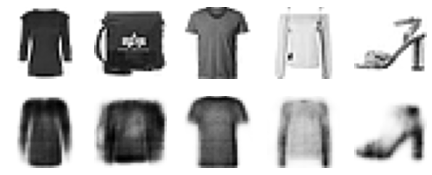

In [11]:
show_reconstructions(stacked_ae)

### Visualizing the Fashion MNIST Dataset

In [12]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

(-0.04822666347026825,
 1.0127599328756332,
 0.03041448704898357,
 1.0461707387119532)

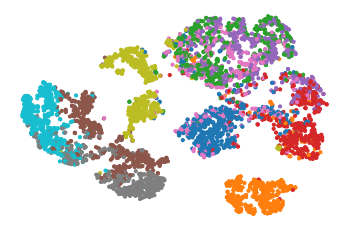

In [13]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis('off')

### Tying Weights

In [14]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.biases = self.add_weight(name='bias', initializer='zeros',
                                  shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)

  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [17]:
tied_ae.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1.5),
                metrics=[rounded_accuracy])

In [18]:
history = tied_ae.fit(X_train, X_train, epochs=20,
                      validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9077
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3017 - val_rounded_accuracy: 0.9087
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2874 - val_rounded_accuracy: 0.9313
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9353
Epoch 7/20
1719/1719 [==================

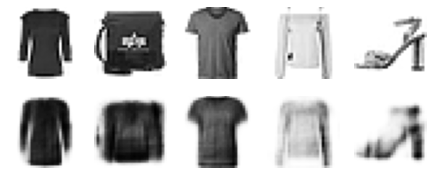

In [19]:
show_reconstructions(tied_ae)

## Training one Autoencoder at a Time

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
  n_inputs = X_train.shape[-1]
  encoder = keras.models.Sequential([
    keras.layers.Dense(n_neurons, activation='selu', input_shape=[n_inputs])
  ])
  decoder = keras.models.Sequential([
    keras.layers.Dense(n_inputs, activation=output_activation, input_shape=[n_neurons])
  ])
  autoencoder = keras.models.Sequential([encoder, decoder])
  autoencoder.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  autoencoder.fit(X_train, X_train, epochs=n_epochs,
                  validation_data=(X_valid, X_valid))
  return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
tf.random.set_seed(42)
np.random.seed(42)
K = keras.backend

In [22]:
X_train_flat = K.batch_flatten(X_train)     # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, 'binary_crossentropy',
    keras.optimizers.SGD(lr=1.5), output_activation='sigmoid',
    metrics=[rounded_accuracy]
)

enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, 'mse',
    keras.optimizers.SGD(lr=0.05), output_activation='selu'
)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [23]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

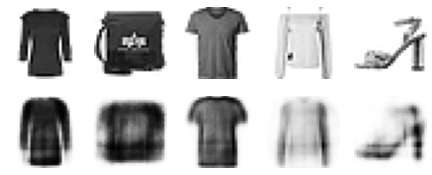

In [24]:
show_reconstructions(stacked_ae_1_by_1)

In [25]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1),
                          metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

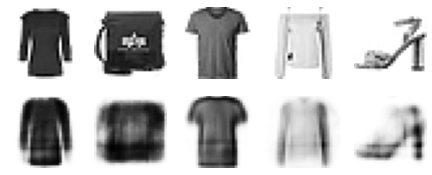

In [26]:
show_reconstructions(stacked_ae_1_by_1)

# Convolutional Autoencoders

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

In [30]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                                 activation='selu', input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                                 activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                                 activation='selu'),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
conv_ae.fit(X_train, X_train, epochs=10,
            validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 10.8860 - rounded_accuracy: 0.3146 - val_loss: 10.8499 - val_rounded_accuracy: 0.3176
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 10.8907 - rounded_accuracy: 0.3144 - val_loss: 10.8499 - val_rounded_accuracy: 0.3176
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 10.8907 - rounded_accuracy: 0.3144 - val_loss: 10.8499 - val_rounded_accuracy: 0.3176
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 10.8907 - rounded_accuracy: 0.3144 - val_loss: 10.8499 - val_rounded_accuracy: 0.3176
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 10.8907 - rounded_accuracy: 0.3144 - val_loss: 10.8499 - val_rounded_accuracy: 0.3176
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 10.8907 - rounded_accuracy: 0.3144 - val_loss: 10.8499 - val_rounded_accuracy: 0.3176
Epoch 7/10
1719/1719 [======

In [31]:
conv_encoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)        

In [32]:
conv_decoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


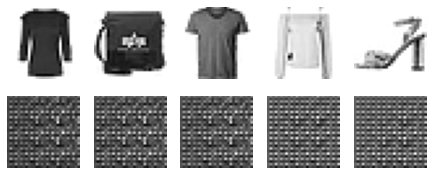

In [33]:
show_reconstructions(conv_ae)

# Recurrent Autoencoders

In [34]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [35]:
recurrent_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=0.1),
                     metrics=[rounded_accuracy])

In [36]:
recurrent_ae.fit(X_train, X_train, epochs=10,
                 validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3743 - val_rounded_accuracy: 0.8679
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3602 - val_rounded_accuracy: 0.8769
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3524 - val_rounded_accuracy: 0.8773
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3362 - val_rounded_accuracy: 0.8923
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3307 - val_rounded_accuracy: 0.8963
Epoch 7/10
1719/1719 [============

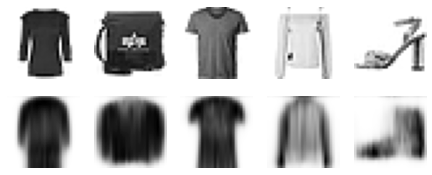

In [37]:
show_reconstructions(recurrent_ae)

# Denoising Autoencoders

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

# Using Gaussian noise
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])

In [40]:
denoising_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
denoising_ae.fit(X_train, X_train, epochs=20,
                 validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3174 - val_rounded_accuracy: 0.9052
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9121
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2977 - val_rounded_accuracy: 0.9237
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/20
1719/1719 [==================

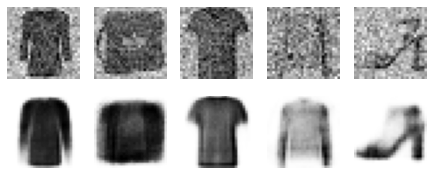

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

In [42]:
# Using dropout
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [43]:
dropout_ae.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
dropout_ae.fit(X_train, X_train, epochs=20,
               validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/20
1719/1719 [==================

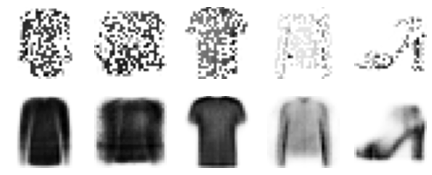

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

# Sparse Autoencoders

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [46]:
sparse_l1_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
sparse_l1_ae.fit(X_train, X_train, epochs=20,
                 validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/20
1719/1719 [==================

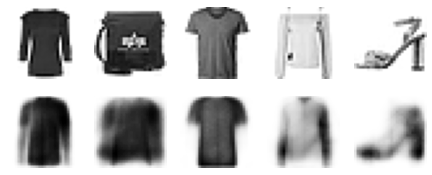

In [47]:
show_reconstructions(sparse_l1_ae)

In [50]:
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target

  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * (
        kl_divergence(self.target, mean_activities) +
        kl_divergence(1. - self.target, 1. - mean_activities)
    )

In [51]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='selu', activity_regularizer=kld_reg),
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

In [52]:
sparse_kl_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
sparse_kl_ae.fit(X_train, X_train, epochs=20,
                 validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 4.0754 - rounded_accuracy: 0.6924 - val_loss: 5.5582 - val_rounded_accuracy: 0.6770
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 5.5405 - rounded_accuracy: 0.6784 - val_loss: 5.5460 - val_rounded_accuracy: 0.6779
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 5.5360 - rounded_accuracy: 0.6783 - val_loss: 5.5635 - val_rounded_accuracy: 0.6763
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 5.5425 - rounded_accuracy: 0.6778 - val_loss: 5.5591 - val_rounded_accuracy: 0.6765
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 5.5410 - rounded_accuracy: 0.6783 - val_loss: 5.5756 - val_rounded_accuracy: 0.6760
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 5.5694 - rounded_accuracy: 0.6766 - val_loss: 5.6160 - val_rounded_accuracy: 0.6734
Epoch 7/20
1719/1719 [==================

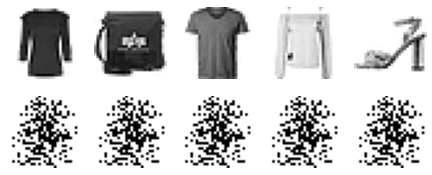

In [53]:
show_reconstructions(sparse_kl_ae)

# Variational Autoencoders

In [54]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [57]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28 * 28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(
    inputs=[decoder_inputs], outputs=[outputs]
)

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1
)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy',
                       optimizer='rmsprop',
                       metrics=[rounded_accuracy])

variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                   validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3894 - rounded_accuracy: 0.8612 - val_loss: 0.3507 - val_rounded_accuracy: 0.8976
Epoch 2/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3425 - rounded_accuracy: 0.8980 - val_loss: 0.3367 - val_rounded_accuracy: 0.9057
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3326 - rounded_accuracy: 0.9054 - val_loss: 0.3323 - val_rounded_accuracy: 0.9047
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3277 - rounded_accuracy: 0.9092 - val_loss: 0.3306 - val_rounded_accuracy: 0.9107
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3246 - rounded_accuracy: 0.9119 - val_loss: 0.3262 - val_rounded_accuracy: 0.9143
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3224 - rounded_accuracy: 0.9138 - val_loss: 0.3232 - val_rounded_accuracy: 0.9133
Epoch 7/25
430/430 [==============================] 

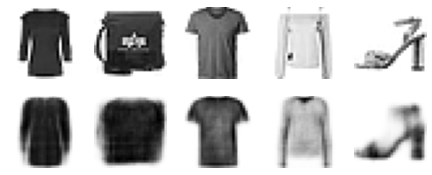

In [58]:
show_reconstructions(variational_ae)

In [66]:
# Trying to remove redundance
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28 * 28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(
    inputs=[decoder_inputs], outputs=[outputs]
)

# _, _, codings = variational_encoder(inputs)    # Remove this line
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1
)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy',
                       optimizer='rmsprop',
                       metrics=[rounded_accuracy])

variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                   validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3911 - rounded_accuracy: 0.8594 - val_loss: 0.3490 - val_rounded_accuracy: 0.8921
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3430 - rounded_accuracy: 0.8974 - val_loss: 0.3397 - val_rounded_accuracy: 0.8975
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3329 - rounded_accuracy: 0.9051 - val_loss: 0.3354 - val_rounded_accuracy: 0.9068
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3277 - rounded_accuracy: 0.9095 - val_loss: 0.3279 - val_rounded_accuracy: 0.9119
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3242 - rounded_accuracy: 0.9122 - val_loss: 0.3274 - val_rounded_accuracy: 0.9106
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3221 - rounded_accuracy: 0.9140 - val_loss: 0.3224 - val_rounded_accuracy: 0.9142
Epoch 7/25
430/430 [==============================] 

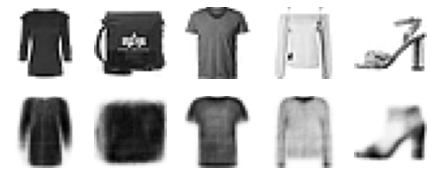

In [67]:
show_reconstructions(variational_ae)

### Generating Fashion MNIST Images

In [68]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

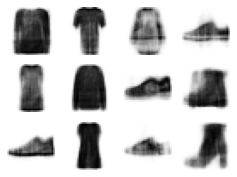

In [69]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

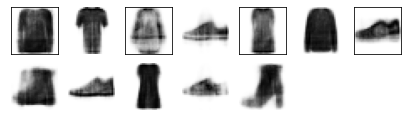

In [71]:
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

# Generative Adversarial Networks

In [72]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28]),
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

gan = keras.models.Sequential([generator, discriminator])

In [73]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [74]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [75]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    for X_batch in dataset:
      # phase 1 - training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.0]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      
      # phase 2 - training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_multiple_images(generated_images, 8)
    plt.show()

Epoch 1/1


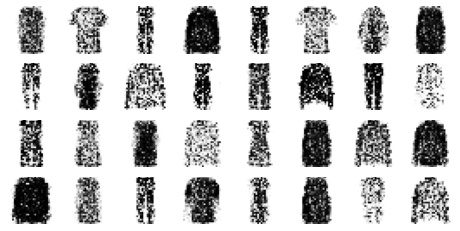

In [76]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

### Deep Convolutional GANs

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                 padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                 padding='same', activation='tanh'),
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same',
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same',
                        activation=keras.layers.LeakyReLU(00.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [78]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [79]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.  # reshape and scale

In [80]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


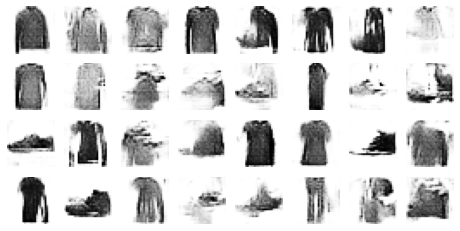

Epoch 2/50


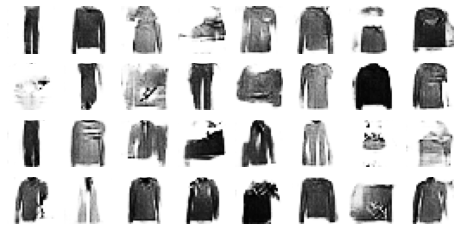

Epoch 3/50


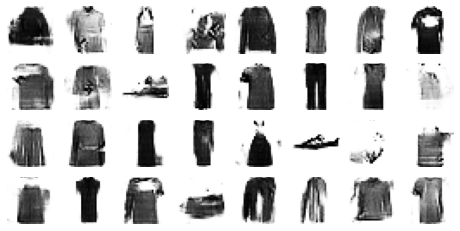

Epoch 4/50


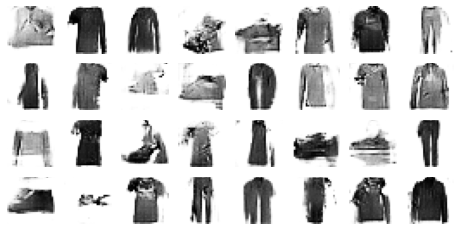

Epoch 5/50


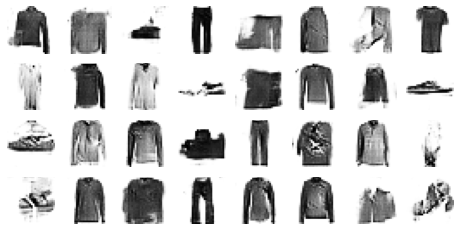

Epoch 6/50


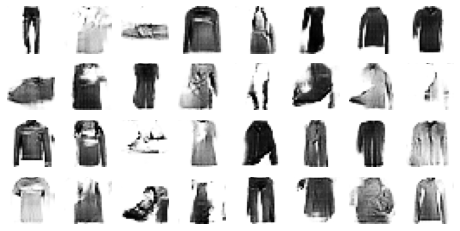

Epoch 7/50


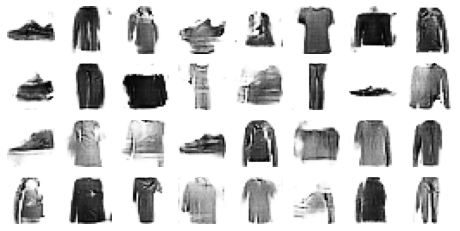

Epoch 8/50


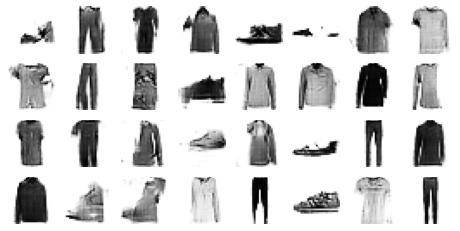

Epoch 9/50


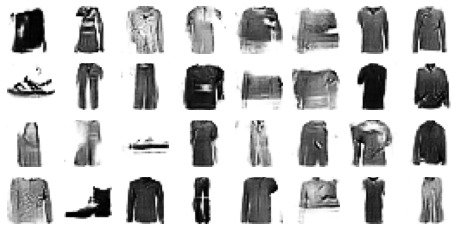

Epoch 10/50


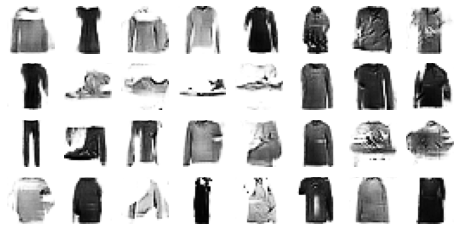

Epoch 11/50


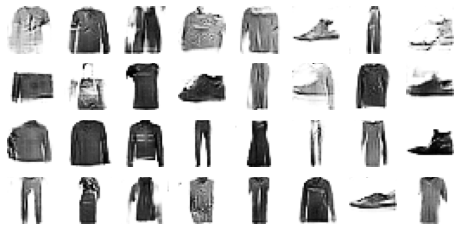

Epoch 12/50


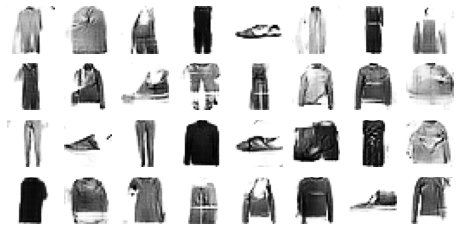

Epoch 13/50


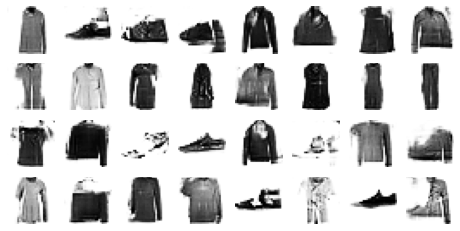

Epoch 14/50


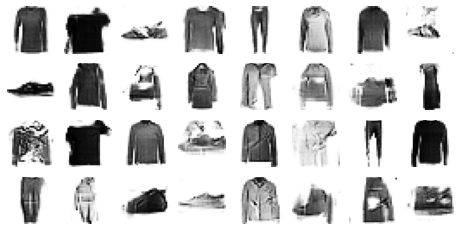

Epoch 15/50


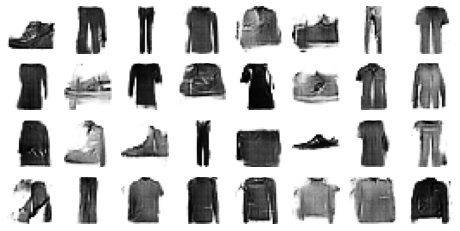

Epoch 16/50


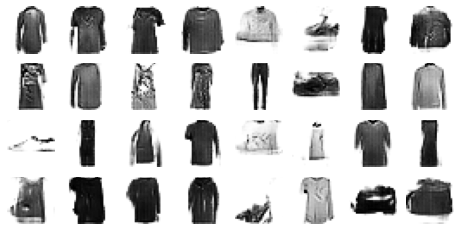

Epoch 17/50


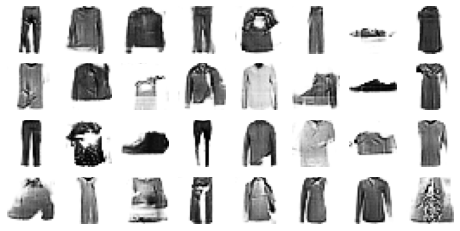

Epoch 18/50


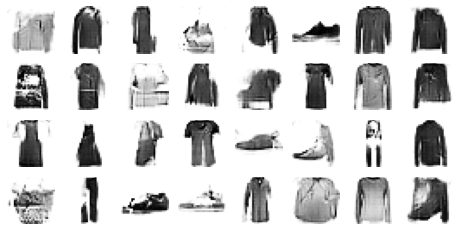

Epoch 19/50


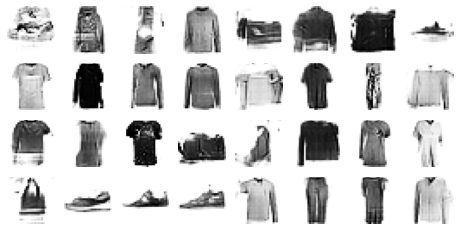

Epoch 20/50


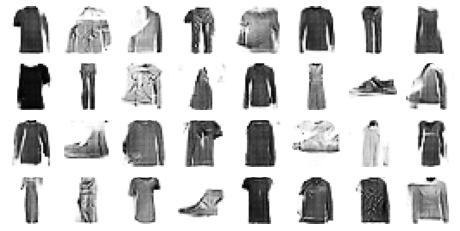

Epoch 21/50


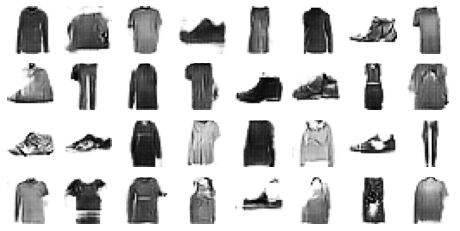

Epoch 22/50


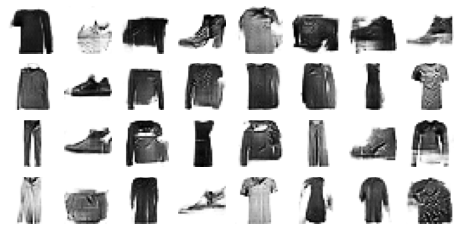

Epoch 23/50


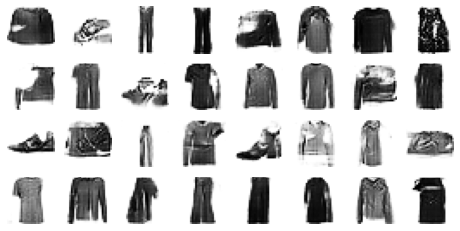

Epoch 24/50


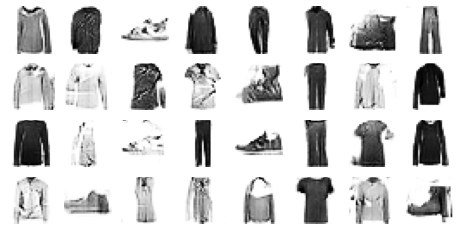

Epoch 25/50


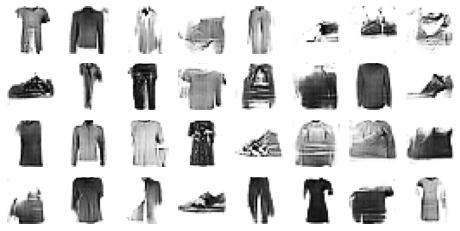

Epoch 26/50


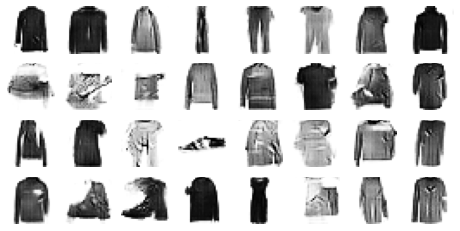

Epoch 27/50


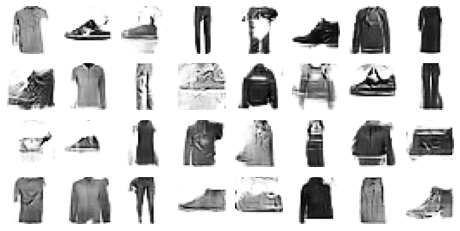

Epoch 28/50


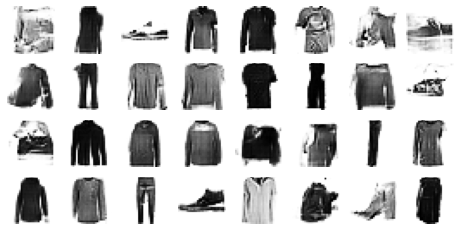

Epoch 29/50


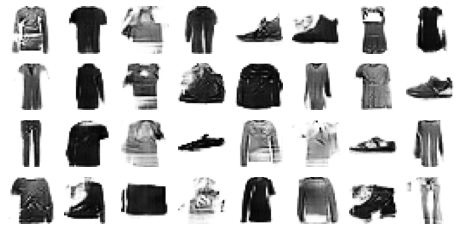

Epoch 30/50


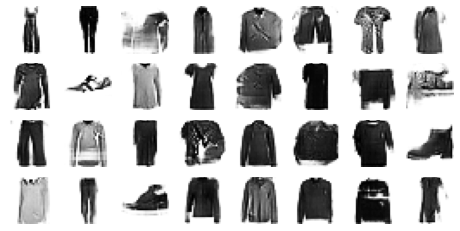

Epoch 31/50


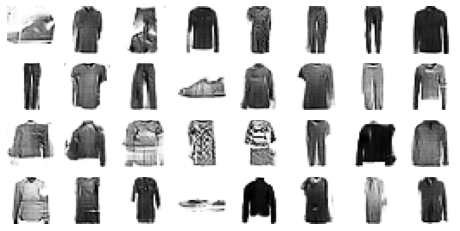

Epoch 32/50


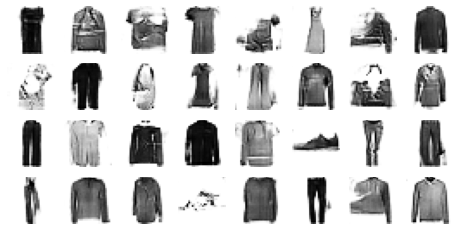

Epoch 33/50


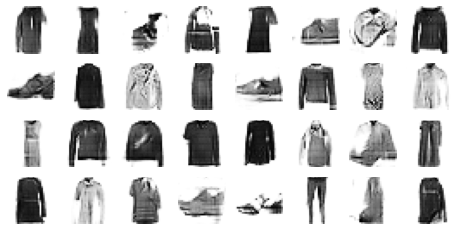

Epoch 34/50


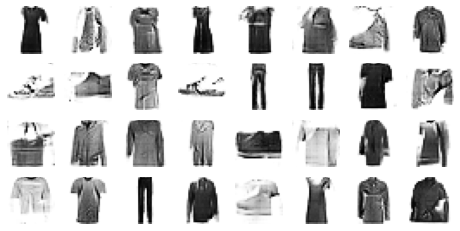

Epoch 35/50


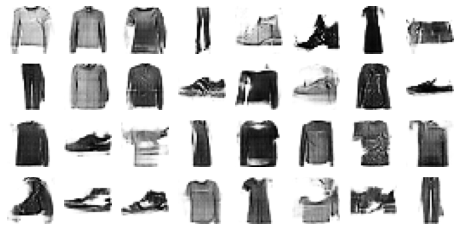

Epoch 36/50


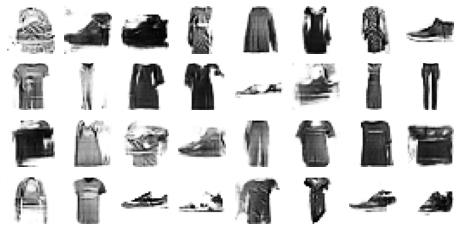

Epoch 37/50


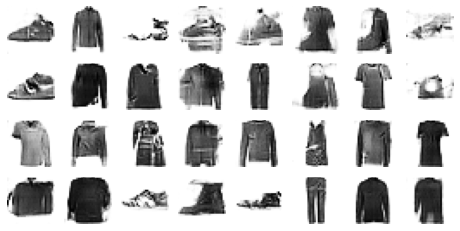

Epoch 38/50


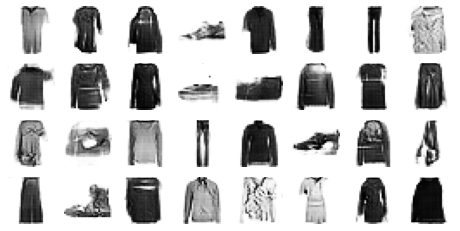

Epoch 39/50


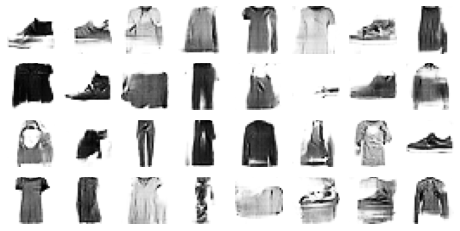

Epoch 40/50


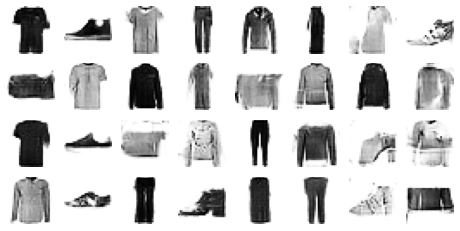

Epoch 41/50


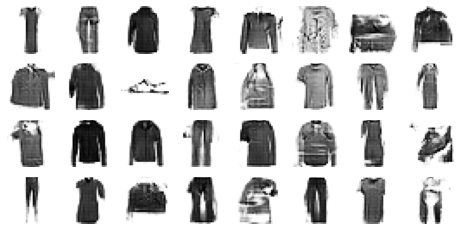

Epoch 42/50


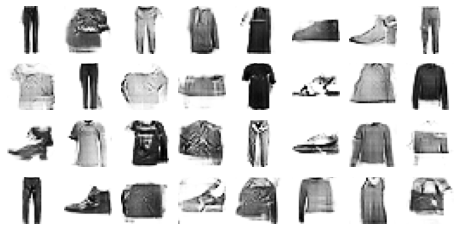

Epoch 43/50


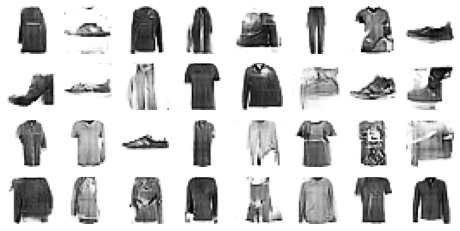

Epoch 44/50


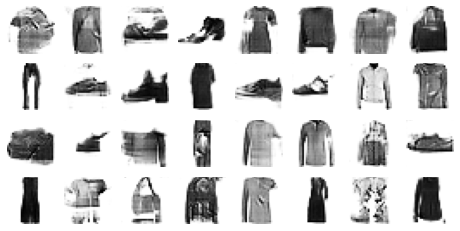

Epoch 45/50


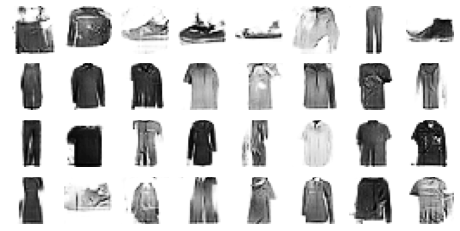

Epoch 46/50


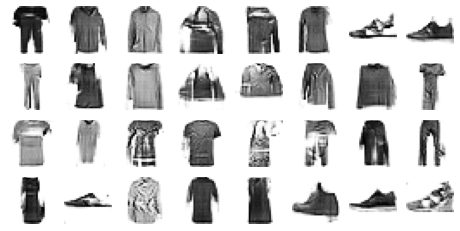

Epoch 47/50


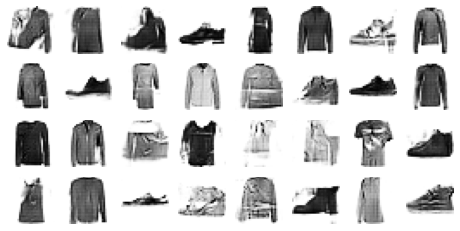

Epoch 48/50


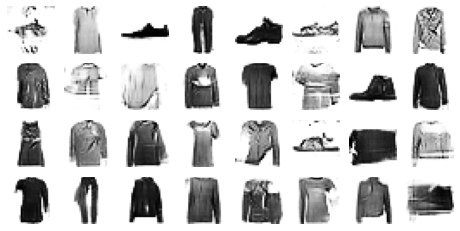

Epoch 49/50


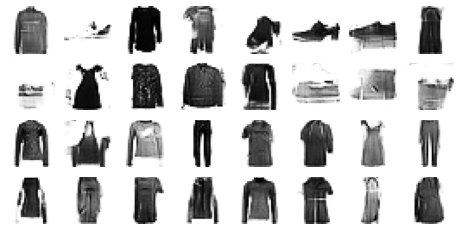

Epoch 50/50


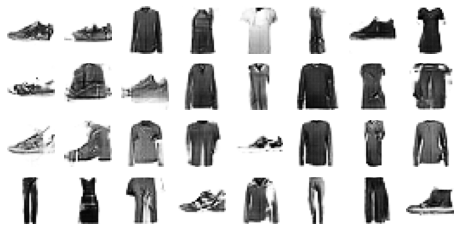

In [81]:
train_gan(gan, dataset, batch_size, codings_size)

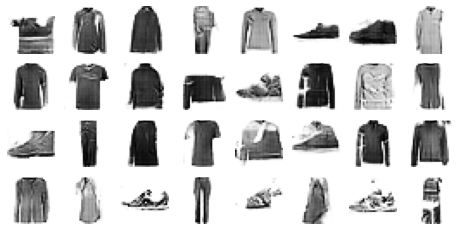

In [82]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

# Exercises

In [83]:
# Question 9
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(10, activation='softmax'),
])

In [84]:
classifier.compile(loss='sparse_categorical_crossentropy',
                   optimizer=keras.optimizers.SGD(lr=0.02),
                   metrics=['accuracy'])
history = classifier.fit(X_train_small, y_train_small, epochs=30,
                         validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 1s 32ms/step - loss: 2.1815 - accuracy: 0.2720 - val_loss: 1.9760 - val_accuracy: 0.4244
Epoch 2/30
16/16 [==============================] - 0s 22ms/step - loss: 1.7818 - accuracy: 0.5340 - val_loss: 1.6221 - val_accuracy: 0.5380
Epoch 3/30
16/16 [==============================] - 0s 23ms/step - loss: 1.4092 - accuracy: 0.5960 - val_loss: 1.2567 - val_accuracy: 0.6080
Epoch 4/30
16/16 [==============================] - 0s 24ms/step - loss: 1.0861 - accuracy: 0.6880 - val_loss: 1.0034 - val_accuracy: 0.6906
Epoch 5/30
16/16 [==============================] - 0s 24ms/step - loss: 0.9613 - accuracy: 0.6820 - val_loss: 0.9212 - val_accuracy: 0.6956
Epoch 6/30
16/16 [==============================] - 0s 25ms/step - loss: 0.8760 - accuracy: 0.7060 - val_loss: 0.8627 - val_accuracy: 0.7012
Epoch 7/30
16/16 [==============================] - 0s 23ms/step - loss: 0.7741 - accuracy: 0.7580 - val_loss: 0.8093 - val_accuracy: 0.7020
Epoch 8/30
16

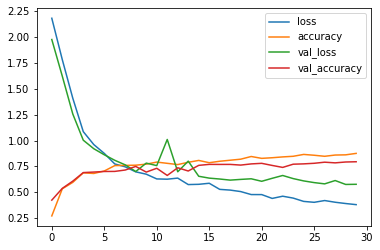

In [85]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [86]:
classifier.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.5774 - accuracy: 0.7952


[0.5774144530296326, 0.795199990272522]

In [93]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                                 activation='selu'),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                                 activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                                 activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [94]:
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.))
history = conv_ae.fit(X_train, X_train, epochs=20,
                      validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3018 - val_loss: 0.2849
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2756 - val_loss: 0.2729
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2708 - val_loss: 0.2696
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2682 - val_loss: 0.2685
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2664 - val_loss: 0.2672
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2651 - val_loss: 0.2658
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2640 - val_loss: 0.2648
Epoch 8/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2631 - val_loss: 0.2652
Epoch 9/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2624 - val_loss: 0.2635
Epoch 10/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.261

In [95]:
tf.random.set_seed(42)
np.random.seed(42)
conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(10, activation='softmax'),
])

In [96]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=['accuracy'])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 30ms/step - loss: 2.3133 - accuracy: 0.1680 - val_loss: 2.2306 - val_accuracy: 0.2382
Epoch 2/30
16/16 [==============================] - 0s 25ms/step - loss: 2.1850 - accuracy: 0.2760 - val_loss: 2.1302 - val_accuracy: 0.3560
Epoch 3/30
16/16 [==============================] - 0s 24ms/step - loss: 2.0876 - accuracy: 0.4000 - val_loss: 2.0362 - val_accuracy: 0.4132
Epoch 4/30
16/16 [==============================] - 0s 24ms/step - loss: 1.9943 - accuracy: 0.4720 - val_loss: 1.9561 - val_accuracy: 0.5152
Epoch 5/30
16/16 [==============================] - 0s 26ms/step - loss: 1.9140 - accuracy: 0.5520 - val_loss: 1.8746 - val_accuracy: 0.5920
Epoch 6/30
16/16 [==============================] - 0s 25ms/step - loss: 1.8325 - accuracy: 0.6400 - val_loss: 1.7987 - val_accuracy: 0.6340
Epoch 7/30
16/16 [==============================] - 0s 26ms/step - loss: 1.7564 - accuracy: 0.6660 - val_loss: 1.7221 - val_accuracy: 0.6414
Epoch 8/30
16

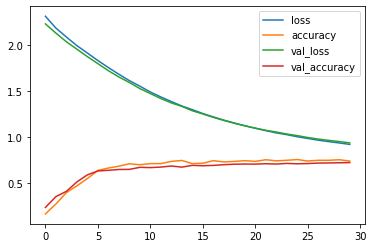

In [97]:
pd.DataFrame(history.history).plot()

In [98]:
pretrained_clf.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.9391 - accuracy: 0.7250


[0.9390634894371033, 0.7250000238418579]

In [99]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=['accuracy'])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=(X_valid, y_valid))

Epoch 1/20
16/16 [==============================] - 0s 29ms/step - loss: 0.8376 - accuracy: 0.7440 - val_loss: 0.7985 - val_accuracy: 0.7202
Epoch 2/20
16/16 [==============================] - 0s 23ms/step - loss: 0.7375 - accuracy: 0.7680 - val_loss: 0.7909 - val_accuracy: 0.7222
Epoch 3/20
16/16 [==============================] - 0s 23ms/step - loss: 0.7181 - accuracy: 0.7640 - val_loss: 0.7748 - val_accuracy: 0.7072
Epoch 4/20
16/16 [==============================] - 0s 24ms/step - loss: 0.6707 - accuracy: 0.7800 - val_loss: 0.7188 - val_accuracy: 0.7302
Epoch 5/20
16/16 [==============================] - 0s 23ms/step - loss: 0.6548 - accuracy: 0.7600 - val_loss: 0.6878 - val_accuracy: 0.7436
Epoch 6/20
16/16 [==============================] - 0s 22ms/step - loss: 0.6423 - accuracy: 0.7760 - val_loss: 0.7111 - val_accuracy: 0.7298
Epoch 7/20
16/16 [==============================] - 0s 23ms/step - loss: 0.5993 - accuracy: 0.8060 - val_loss: 0.6918 - val_accuracy: 0.7344
Epoch 8/20
16

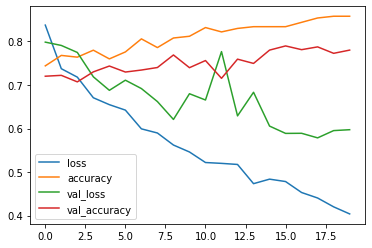

In [100]:
pd.DataFrame(history.history).plot()

In [101]:
pretrained_clf.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.5973 - accuracy: 0.7802


[0.597295880317688, 0.7802000045776367]

In [102]:
# using denoising autoencoder
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])

In [104]:
denoising_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=1.0))
history = denoising_ae.fit(X_train, X_train, epochs=30,
                           validation_data=(X_valid, X_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3509 - val_loss: 0.3182
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3121 - val_loss: 0.3087
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3057 - val_loss: 0.3035
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3021 - val_loss: 0.2999
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2992 - val_loss: 0.2968
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2969 - val_loss: 0.2947
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2953 - val_loss: 0.2946
Epoch 8/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2940 - val_loss: 0.2931
Epoch 9/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2931 - val_loss: 0.2923
Epoch 10/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.292

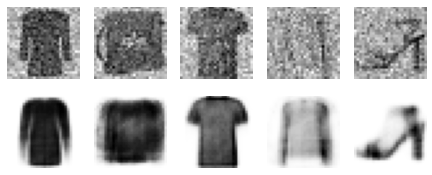

In [105]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

In [108]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder_clone = keras.models.clone_model(denoising_encoder)

pretrained_clf = keras.models.Sequential([
    denoising_encoder,
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(10, activation='softmax'),
])

In [109]:
denoising_encoder.trainable = False
pretrained_clf.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=['accuracy'])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 1s 45ms/step - loss: 3.2278 - accuracy: 0.2400 - val_loss: 1.5901 - val_accuracy: 0.4650
Epoch 2/30
16/16 [==============================] - 0s 20ms/step - loss: 1.3958 - accuracy: 0.4960 - val_loss: 1.1182 - val_accuracy: 0.6246
Epoch 3/30
16/16 [==============================] - 0s 20ms/step - loss: 1.0840 - accuracy: 0.6400 - val_loss: 0.9883 - val_accuracy: 0.6446
Epoch 4/30
16/16 [==============================] - 0s 20ms/step - loss: 0.9584 - accuracy: 0.6700 - val_loss: 0.9316 - val_accuracy: 0.6702
Epoch 5/30
16/16 [==============================] - 0s 21ms/step - loss: 0.9147 - accuracy: 0.6540 - val_loss: 0.8972 - val_accuracy: 0.6750
Epoch 6/30
16/16 [==============================] - 0s 20ms/step - loss: 0.8825 - accuracy: 0.6920 - val_loss: 0.8712 - val_accuracy: 0.6766
Epoch 7/30
16/16 [==============================] - 0s 21ms/step - loss: 0.8301 - accuracy: 0.7100 - val_loss: 0.8386 - val_accuracy: 0.6996
Epoch 8/30
16

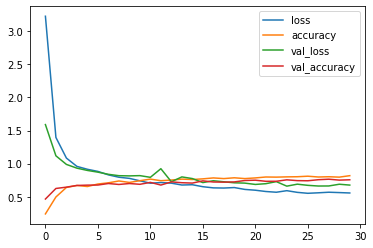

In [110]:
pd.DataFrame(history.history).plot()

In [111]:
pretrained_clf.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.7560


[0.6757045388221741, 0.7559999823570251]

In [112]:
denoising_encoder.trainable = True
pretrained_clf.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=['accuracy'])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 0s 25ms/step - loss: 0.5499 - accuracy: 0.8100 - val_loss: 0.6558 - val_accuracy: 0.7538
Epoch 2/30
16/16 [==============================] - 0s 21ms/step - loss: 0.5433 - accuracy: 0.8160 - val_loss: 0.6659 - val_accuracy: 0.7652
Epoch 3/30
16/16 [==============================] - 0s 20ms/step - loss: 0.5222 - accuracy: 0.8080 - val_loss: 0.6409 - val_accuracy: 0.7670
Epoch 4/30
16/16 [==============================] - 0s 20ms/step - loss: 0.5176 - accuracy: 0.8220 - val_loss: 0.6621 - val_accuracy: 0.7646
Epoch 5/30
16/16 [==============================] - 0s 21ms/step - loss: 0.5000 - accuracy: 0.8200 - val_loss: 0.6338 - val_accuracy: 0.7740
Epoch 6/30
16/16 [==============================] - 0s 20ms/step - loss: 0.5122 - accuracy: 0.8300 - val_loss: 0.6270 - val_accuracy: 0.7692
Epoch 7/30
16/16 [==============================] - 0s 20ms/step - loss: 0.4920 - accuracy: 0.8300 - val_loss: 0.6418 - val_accuracy: 0.7660
Epoch 8/30
16

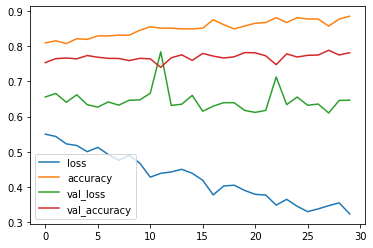

In [113]:
pd.DataFrame(history.history).plot()

In [114]:
pretrained_clf.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.6466 - accuracy: 0.7820


[0.6466226577758789, 0.7820000052452087]